In [1]:
from utils import * 
import pennylane as qml
import os 
from autoencoder8 import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")


emd_comparison =['reconstruction_em_fi','reconstruction_em_em','reconstruction_em_mix']
fid_comparison = ['reconstruction_fidelity_fi','reconstruction_fidelity_em','reconstruction_fidelity_mix']
loss_map = {'x':'Mix',
            'i':'Fid',
            'm':'Emd'}

In [9]:
np.load('out_mix\\out_8to2\\5\\weights(8)(6)_0.npy')- np.load('out_fi\\out_8to2\\5\\weights(8)(6)_0.npy')

array([ 1.70169830e+00, -2.59973481e-01, -8.08383814e-01,  1.26689133e+00,
       -2.93299463e+00,  2.24239570e+00,  3.13632904e+00,  1.36776032e+00,
       -1.36882546e+00, -1.06986370e-01, -1.63025321e+00, -1.85639565e+00,
        1.41206410e+00, -2.28607732e+00,  7.19888331e-01,  1.75857642e+00,
       -1.08045815e+00, -2.04224954e+00,  7.36102241e-03,  3.28196714e+00,
       -3.04718456e+00, -6.58953373e-01, -4.17560187e+00,  1.28916456e+00,
        1.83153598e+00,  3.81977190e-01, -1.22482162e-01, -2.47180101e+00,
        6.87147621e-01,  1.77283360e+00, -1.22903149e+00, -3.79019831e-01,
        3.11317939e+00, -1.80356470e+00,  5.67890633e-01,  4.55570964e-01,
       -1.74845299e+00, -6.02256185e-01, -6.21921961e+00,  1.91853542e+00,
       -4.18005929e+00, -2.57006895e+00,  1.16365076e+00,  2.47078785e-01,
        6.15216144e-01,  6.85437038e-02, -2.70293152e-01, -1.92799803e+00,
        1.03078450e+00, -3.37020870e-02, -1.99171926e+00,  7.78379350e-01,
       -1.11843225e+01, -

In [ ]:
def get_scores(fold):
    if 'fidelity' in fold:
        comparison_metric = 'fidelity'
        k=0    
    else:
        comparison_metric = 'EM_dist'
        k=1
    reses =[]
    for subfolder in os.listdir(fold):
        df = pd.read_csv(os.path.join(fold,subfolder),header = 0)
        if 'Unnamed: 0' in df.columns:
            df.drop(['Unnamed: 0'],axis = 1, inplace=True)
        if comparison_metric = 'fidelity':
            res ={'model':df.file[0],
                'vloss':df.vloss[0],
                'tloss':df.tloss[0],
                comparison_metric:np.mean(df[comparison_metric]),
                'mq':df.mq[0],
                'loss':loss_map[fold[-1]]
                }
        else:            
            res ={'model':df.file[0],
                'vloss':df.vloss[0]/(8-df.mq[0]),
                'tloss':df.tloss[0]/(8-df.mq[0]),
                comparison_metric:np.mean(df[comparison_metric]),
                'mq':df.mq[0],
                'loss':loss_map[fold[-1]]
                }


        reses.append(res)

    return pd.DataFrame(reses)


def plot_comparison(df, metric):
    # Unique models and loss bins
    models = df['model'].unique()
    loss_bins = df['loss'].unique()
    palette1=["#005285","#C414BB", "#A80000"]
    marker_styles = ['o','X','D']  # One for each loss_bin

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot each model + loss bin
    for i, model in enumerate(models):
        model_data = df[df['model'] == model]

        for j, loss_level in enumerate(loss_bins):
            sub_data = model_data[model_data['loss'] == loss_level].sort_values(by='mq')
            if sub_data.empty:
                continue
            
            sns.scatterplot(
                data=sub_data, x='mq', y=metric, ax=ax1,
                color=palette1[j], marker=marker_styles[j],
                size=3
            )
    # Labels
    ax1.set_xlabel("mq")
    ax1.set_ylabel(metric)
    # ax2.set_ylabel("Validation Loss (vloss)")
    plt.title(f"{metric} and vloss vs mq, colored by model, shaped by loss")
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker=marker_styles[g], color='w',
            markerfacecolor=palette1[g], markersize=10, label=loss_bins[g])
        for g in range(3)
    ]

    plt.legend(handles=legend_elements, title="Training loss")

    plt.tight_layout()
    plt.show()


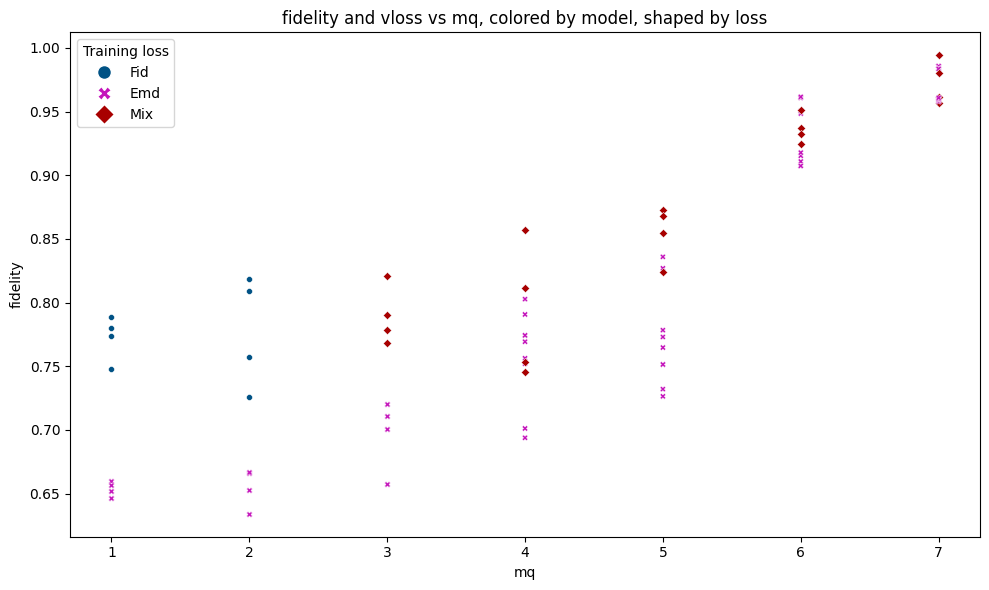

In [3]:
dfs= []
for fold in fid_comparison:
    dfs.append(get_scores(fold))
df = pd.concat(dfs)
plot_comparison(df,'fidelity')

In [4]:
df.columns

Index(['model', 'vloss', 'tloss', 'fidelity', 'mq', 'loss'], dtype='object')

In [5]:
df[((df.loss == 'Fid') | (df.loss == 'Mix')) & (df.mq == 6)]


,model,vloss,tloss,fidelity,mq,loss
20,weights(8)(6)_0.npy,0.016170,0.016977,0.937491,6,Fid
21,weights(8)(6)_1.npy,0.014970,0.018125,0.932509,6,Fid
22,weights(8)(6)_2.npy,0.025212,0.021687,0.924606,6,Fid
23,weights(8)(6)_3.npy,0.011128,0.014553,0.951295,6,Fid
12,weights(8)(6)_0.npy,0.016170,0.016977,0.937491,6,Mix
13,weights(8)(6)_1.npy,0.014970,0.018125,0.932509,6,Mix
14,weights(8)(6)_2.npy,0.025212,0.021687,0.924606,6,Mix
15,weights(8)(6)_3.npy,0.011128,0.014553,0.951295,6,Mix


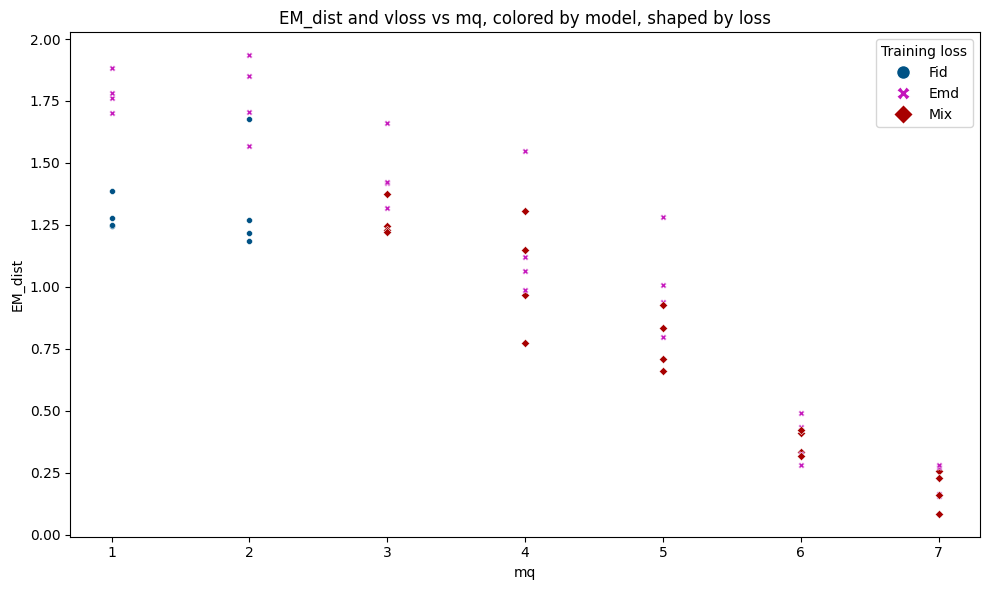

In [6]:
dfs= []
for fold in emd_comparison:
    dfs.append(get_scores(fold))
df = pd.concat(dfs)
plot_comparison(df,'EM_dist')